# Question Generation For Retrieval Evaluation
MLflow provides an advanced framework for constructing Retrieval-Augmented Generation (RAG) models.
RAG is a cutting edge approach that combines the strengths of retrieval models (a model that chooses and ranks relevant 
chunks of a document based on the user's question) and generative models.
It effectively merges the capabilities of searching and generating text to provide responses that are contextually
relevant and coherent, allowing the generated text to make reference to existing documents. RAG leverges the retriever to find context documents, and
this novel approach has revolutionized various NLP tasks.

Naturally, we want to be able to evaluate this retriever system for the RAG model to compare and judge its
performance. To evaluate a retriever system, we would first need a test set of questions on the documents.
These questions need to be diverse, relevant, and coherent. Manually generating questions may be challenging
because it first requires you to understand the documents, and spend lots of time coming up with questions 
for them. 

We want to make this process simpler by utilizing an LLM to generate questions for this test set. This
tutorial will walk through how to generate the questions and how to analyze the diversity and relevance
of the questions.

## Step 1: Install and Load Packages

In [ ]:
import os
from langchain.docstore.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
import openai

# For scraping
import requests
import pandas as pd
from bs4 import BeautifulSoup

# For data analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import random

## Step 2: Set OpenAI Key
The question generation system can be done using any LLM. We chose to use OpenAI here, so we will need their API key.

In [ ]:
openai.api_key = "<redacted>"
os.environ["OPENAI_API_KEY"] = "<redacted>"

## Step 3: Decide on chunk size and number of questions per chunk

In [ ]:
CHUNK_SIZE = 1500
QUESTIONS_PER_CHUNK = 5
NUM_DOCUMENTS = 40  # Number of scraped chunks to use

## Step 4: Get Document Data
We scrape the documents from the MLflow website to use to generate questions.

In [ ]:
page = requests.get("https://mlflow.org/docs/latest/index.html")
soup = BeautifulSoup(page.content, "html.parser")

mainLocation = "https://mlflow.org/docs/latest/"
header = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11",
    "Accept-Language": "en-US,en;q=0.8",
    "Connection": "keep-alive",
}

data = []
for a_link in soup.find_all("a"):
    document_url = mainLocation + a_link["href"]
    page = requests.get(document_url, headers=header)
    soup = BeautifulSoup(page.content, "html.parser")
    file_to_store = a_link.get("href").split("/")[-1]
    if soup.find("div", {"class": "rst-content"}):
        data.append(
            [file_to_store, soup.find("div", {"class": "rst-content"}).text.replace("\n", " ")]
        )

df = pd.DataFrame(data, columns=["source", "text"])
df.head(3)

/databricks/python/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
 warnings.warn(
Out[38]:

,source,text
0,what-is-mlflow.html,Documentation What is MLflow? What i...
1,quickstart.html,"Documentation Quickstart: Install MLflow, ..."
2,quickstart_mlops.html,"Documentation Quickstart: Compare runs, ch..."


## Step 5: Load Document Data
We want to generate questions based on a set of documents. Here, we load the documents as Langchain Documents and utilize their embedding models. Through Langchain Documents, each document is broken down into a "chunk", which is a snippet of the text.

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=CHUNK_SIZE, separator=" ")
documents = []
for index, page in df.iterrows():
    chunks = text_splitter.split_text(page[1])
    for chunk in chunks:
        documents.append(Document(page_content=chunk))
print(documents[0])

page_content='Documentation What is MLflow? What is MLflow? MLflow is a versatile, expandable, open-source platform for managing workflows and artifacts across the machine learning lifecycle. It has built-in integrations with many popular ML libraries, but can be used with any library, algorithm, or deployment tool. It is designed to be extensible, so you can write plugins to support new workflows, libraries, and tools. MLflow has five components: MLflow Tracking: An API for logging parameters, code versions, metrics, model environment dependencies, and model artifacts when running your machine learning code. MLflow Tracking has a UI for reviewing and comparing runs and their results. This image from the MLflow Tracking UI shows a chart linking metrics (learning rate and momentum) to a loss metric: MLflow Models: A model packaging format and suite of tools that let you easily deploy a trained model (from any ML library) for batch or real-time inference on platforms such as Docker, Apache Spark, Databricks, Azure ML and AWS SageMaker. This image shows MLflow Tracking UI’s view of a run’s detail and its MLflow model. You can see that the artifacts in the model directory include the model weights, files describing the model’s environment and dependencies, and sample code for loading the model and inferencing with it: MLflow Model Registry: A centralized model store, set of APIs, and UI focused on the approval, quality assurance, and deployment of an MLflow Model.' metadata={}

## Step 6: Generate Questions
The goal here is to generate questions that are coherant and contextually relevant to their respective document chunk. You can use any LLM, but in this tutorial we chose to generate the list of questions with OpenAI GPT3.5. We also utilize prompt engineering to produce better quality questions, as we found it to be a simple and effective way to improve the responses. In particular, we found two changes to be helpful:
- Better quality questions were produced if you ask the model for multiple questions per chunk rather than just one. This may be because it can ensure local diversity, better formatting, and have an implicit understanding that you are trying to get a list of questions.
- We observed that some questions reference the document without explaining what it is referencing, hence we include this in the prompt explicitly to help with this.

In [ ]:
queries = []
for doc in documents[:NUM_DOCUMENTS]:
    chunk = doc.page_content
    chunks.append(chunk)
    params = {
        "model": "gpt-3.5-turbo",
        "messages": [
            {
                "role": "user",
                "content": f"{chunk}.\n Please generate {QUESTIONS_PER_CHUNK} questions based on the above document. The questions should be diverse and ask for different aspects of the document. Don't give vague references to the document without description. Split each question with a newline",
            }
        ],
    }

    response = openai.ChatCompletion.create(**params)
    response_queries = response.choices[0].message.content

    question_list = []
    for q in response_queries.splitlines():
        q = " ".join(q.split()[1:])
        question_list.append(q)

    queries.append({"chunk": chunk, "questions": question_list})

print(queries[0])

{'chunk': 'Documentation What is MLflow? What is MLflow? MLflow is a versatile, expandable, open-source platform for managing workflows and artifacts across the machine learning lifecycle. It has built-in integrations with many popular ML libraries, but can be used with any library, algorithm, or deployment tool. It is designed to be extensible, so you can write plugins to support new workflows, libraries, and tools. MLflow has five components: MLflow Tracking: An API for logging parameters, code versions, metrics, model environment dependencies, and model artifacts when running your machine learning code. MLflow Tracking has a UI for reviewing and comparing runs and their results. This image from the MLflow Tracking UI shows a chart linking metrics (learning rate and momentum) to a loss metric: MLflow Models: A model packaging format and suite of tools that let you easily deploy a trained model (from any ML library) for batch or real-time inference on platforms such as Docker, Apache Spark, Databricks, Azure ML and AWS SageMaker. This image shows MLflow Tracking UI’s view of a run’s detail and its MLflow model. You can see that the artifacts in the model directory include the model weights, files describing the model’s environment and dependencies, and sample code for loading the model and inferencing with it: MLflow Model Registry: A centralized model store, set of APIs, and UI focused on the approval, quality assurance, and deployment of an MLflow Model.', 'questions': ['What is the purpose of MLflow Tracking and what are some of the information it logs?', 'How does MLflow Models help with deploying trained models and on what platforms can it be used?', 'Can MLflow be used with any ML library, algorithm, or deployment tool?', 'What are some key features of MLflow Model Registry and how does it assist with model deployment?', 'How does MLflow support extensibility and what can be achieved by writing plugins for it?']}

## Quality Analysis of Questions Generated (Optional)
If you would like to compare quality of questions generated across different prompts, we can
analyze the quality of questions manually and in aggregate. We want to evaluate questions 
along two dimensions - their diversity and relevance.

Note: There isn't a well-defined way to analyze the quality of generated questions, so this is just one approach you can take to gain insight into how diverse and relevant your generated questions are.

### Evaluating Diversity of Questions

Diversity of questions is important because we want questions to cover the majority of the
document content. In addition, we want to be able to evaluate the retriever with different 
forms of questioning. We want to be able to have harder questions and easier questions. All
of these are not straightforward to analyze, and we decided to analyze its through question
length and latent space embeddings.

In [ ]:
# Get all the questions in a list
questions = []
for query in queries:
    questions += query["questions"]

#### Length
Length gives a sense of how diverse the questions are. Some questions may be wordy while
others are straight to the point. It also allows us to identify problems with the question
generated. For example, you may identify some questions to have a length of 0.

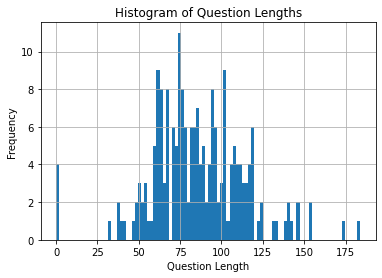

In [ ]:
# Length
question_len = pd.DataFrame([len(q) for q in questions], columns=["length"])
question_len.hist(bins=100)
plt.title("Histogram of Question Lengths")
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.show()

In addition to visual representation, we also want to look at more concrete percentile values.


In [ ]:
# Calculating percentile values
p10 = int(question_len["length"].quantile(0.10))
p90 = int(question_len["length"].quantile(0.90))
print("p10-p90 range is", p90 - p10)

p10-p90 range is 61

We noticed that the short queries are all empty strings, and hence we need to filter for this.

In [ ]:
[q for q in questions if len(q) < 5]

Out[51]: ['', '', '', '']

There are also a couple queries that are longer than normal. However, these seem fine.

In [ ]:
[q for q in questions if len(q) > 160]

Out[52]: ['What is the default backend and artifact store used in the MLflow tracking server? How can a user customize these stores by supplying arguments to the mlflow server command?',
 'How are MLflow entities and artifacts recorded in Scenario 2? Describe the interfaces used by the MLflow client to store artifacts and save MLflow entities to the SQLite database file.']

#### Latent Space
Latent space embeddings contain semantic information about the question. This can be used to 
evaluate the diversity and the difference between two questions semantically. To do so, we will need to map the
high dimensional space to a lower dimensional space. We utilize PCA and TSNE to map the embeddings 
into a 2-dimensional space for visualization.

In [ ]:
# post process to remove empty questions
questions_to_embed = [q for q in questions if len(q) > 0]

We append 5 benchmark queries to help visualize how diverse the questions are. The first four of these questions are semantically similar and all asking about MLflow, while the last is different and refers to spark and model registry.

In [ ]:
benchmark_questions = [
    "What is MLflow?",
    "What is MLflow about?",
    "Tell me about MLflow Tracking",
    "How does MLflow work?",
    "How is spark used in model registry?",
]
questions_to_embed = questions_to_embed + benchmark_questions

We apply PCA to reduce the embedding dimensions to 50 before applying TSNE to reduce it to 2 dimensions, as recommended by sklearn due to the computational complexity of TSNE.

In [ ]:
# Apply embeddings
embeddings = OpenAIEmbeddings()
question_embeddings = embeddings.embed_documents(questions_to_embed)
# PCA on embeddings to reduce to 50-dim
pca = PCA(n_components=50)
question_embeddings_50 = pca.fit_transform(question_embeddings)
# TSNE on embeddings to reduce to 2-dim
tsne = TSNE(n_components=2)
lower_dim_embeddings = tsne.fit_transform(question_embeddings_50)

Now that we have 2-dimensional embeddings representing the semantics of the question, we can visualize it with a scatter plot, differentiating the generated questions and the benchmark questions.

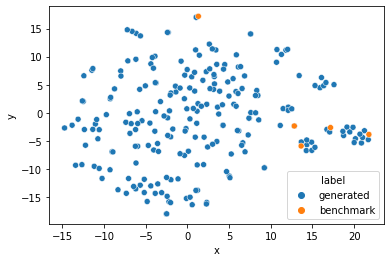

In [ ]:
labels = np.concatenate(
    [
        np.full(len(lower_dim_embeddings) - len(benchmark_questions), "generated"),
        np.full(len(benchmark_questions), "benchmark"),
    ]
)
data = pd.DataFrame(
    {"x": lower_dim_embeddings[:, 0], "y": lower_dim_embeddings[:, 1], "label": labels}
)
sns.scatterplot(data=data, x="x", y="y", hue="label");

Observe that within the orange points on the scatter plot, there is one point that is further than the others. That is the unique benchmark question about Spark and Model Registry. This plot gives a sense of the diversity of the questions generated.

### Evaluate Document Relevance
Another important axis to consider is how relevant the questions are to the document we provided. We want to understand whether the questions generated by the LLM is actually referring to our provided text, or whether it is hallucinating irrelevant questions. We will evaluate relevance by first manually checking certain questions against their document chunk. Then, we define a measure of relevance to analyze it quantitatively.

#### Manual Checking of Document Relevance

Manual qualitative check of whether the questions are relevant to the document.

In [ ]:
samples = 3  # num of chunks we want to observe

for query in random.sample(queries, samples):
    print("Chunk:", query["chunk"])
    for q in query["questions"]:
        print("Question:", q)
    print("-" * 80)  # delimiter

Chunk: represents a run and associates each hyperparameter evaluation run’s parameters to the evaluated error metric for the run. The red graphs on this graph are runs that fared poorly. The lowest one is a baseline run with both lr and momentum set to 0.0. That baseline run has an RMSE of ~0.89. The other red lines show that high momentum can also lead to poor results with this problem and architecture. The graphs shading towards blue are runs that fared better. Hover your mouse over individual runs to see their details. Register your best model Choose the best run and register it as a model. In the Table view, choose the best run. In the Run Detail page, open the Artifacts section and select the Register Model button. In the Register Model dialog, enter a name for the model, such as wine-quality, and click Register. Now, your model is available for deployment. You can see it in the Models page of the MLflow UI. Open the page for the model you just registered. You can add a description for the model, add tags, and easily navigate back to the source run that generated this model. You can also transition the model to different stages. For example, you can transition the model to Staging to indicate that it is ready for testing. You can transition it to Production to indicate that it is ready for deployment. Transition the model to Staging by choosing the Stage dropdown: Serve the model locally MLflow allows you to easily serve models produced by any run or model version. You
Question: What factors are indicated by the red graphs in the given graph and how do they affect the performance of the runs?
Question: What is the significance of the baseline run with lr and momentum set to 0.0 in terms of error metric and performance?
Question: How can high momentum affect the results of the problem and architecture being analyzed?
Question: How can the best run be chosen and registered as a model in the MLflow UI?
Question: How does MLflow enable the serving of models locally and what are the benefits of this functionality?
--------------------------------------------------------------------------------
Chunk: role authentication Part 2c and d: Retrieving artifacts from the configured backend store for a user request is done with the same authorized authentication that was configured at server start Artifacts are passed to the end user through the Tracking Server through the interface of the HttpArtifactRepository Note When an experiment is created, the artifact storage location from the configuration of the tracking server is logged in the experiment’s metadata. When enabling proxied artifact storage, any existing experiments that were created while operating a tracking server in non-proxied mode will continue to use a non-proxied artifact location. In order to use proxied artifact logging, a new experiment must be created. If the intention of enabling a tracking server in -serve-artifacts mode is to eliminate the need for a client to have authentication to the underlying storage, new experiments should be created for use by clients so that the tracking server can handle authentication after this migration. Warning The MLflow artifact proxied access service enables users to have an assumed role of access to all artifacts that are accessible to the Tracking Server. Administrators who are enabling this feature should ensure that the access level granted to the Tracking Server for artifact operations meets all security requirements prior to enabling the Tracking Server to operate in a proxied file handling role. Scenario 6: MLflow Tracking Server used exclusively as
Question: How does the MLflow Tracking Server retrieve artifacts from the configured backend store for a user request?
Question: What interface is used by the Tracking Server to pass artifacts to the end user?
Question: How is the artifact storage location logged in the experiment's metadata when an experiment is created?
Question: Can existing experiments created while operat

#### Embeddings Cosine Similarity

The embedding of the chunk and query is placed in the same latent space, and the retriever model would extract similar chunk embeddings to a query embedding. Hence, relevance for the retriever is defined by the distance of embeddings in this latent space.

Cosine similarity is a measure of vector similarity, and can be used to determine the distance of embeddings between the chunk and the query. It is a distance metric that approaches 1 when the question and chunk are similar, and becomes 0 when they are different.

We can use the cosine similarity score directly to measure the relevancy. However, if we just have a cosine similarity score, it is not interpretable without something to compare it to. Hence, we define relative question relevance as:
$$\frac{cossim(chunk, question_q)}{\frac{1}{len(questions)-1}\sum_{i\ !=\ q}cossim(chunk, question_i)}$$
where `question_q` is a question generated from the chunk.

This relative question relevance can measure how much more relevant a question generated from the chunk is compared to a question generated by another chunk in this dataset. It would give a score of above 1 if the question generated from the chunk is more relevant and a score below if its not. We can then use this score to identify any irrelevant questions generated.

In [ ]:
embedded_queries = []
for query in queries:
    embedded_query = {
        "chunk": np.squeeze(embeddings.embed_documents([query["chunk"]])),
        "questions": embeddings.embed_documents(
            [q for q in query["questions"] if len(q) > 0]
        ),  # embedding cant take empty strings
    }
    embedded_queries.append(embedded_query)

In [ ]:
def cossim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


question_relevance = []
for i, query in enumerate(embedded_queries):
    for q_index, question_emb in enumerate(query["questions"]):
        # generate cosine similarity for the chunk the question is generated from
        chunk_sim = cossim(question_emb, query["chunk"])

        # generate average cosine similarity between chunk and irrelevant questions
        avg_irrelevant_cossim = []
        for j, other_query in enumerate(embedded_queries):
            if i != j:
                # supposedly irrelevant questions to the chunk.
                for q_emb in other_query["questions"]:
                    avg_irrelevant_cossim.append(cossim(q_emb, query["chunk"]))
        other_sim = np.average(avg_irrelevant_cossim)
        question_relevance.append(
            {
                "question": queries[i]["questions"][q_index],  # text version of question
                "chunk": queries[i]["chunk"],  # text version of chunk
                "score": chunk_sim / other_sim,  # relative similarity score
            }
        )

After we score each question by its relative relevancy, we can evaluate the generated questions as a whole.

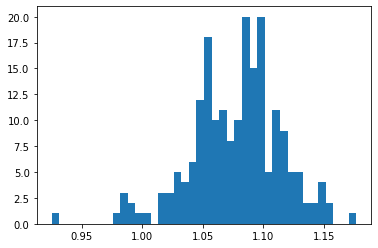

In [ ]:
# score above 1 means it is more relevant to its chunk than other chunks in the document (relative relevance). This shows that most chunks are relatively relevant.
scores = [x["score"] for x in question_relevance]
plt.hist(scores, bins=40);

There are a couple scores that are less than 1, lets take a look at those.

In [ ]:
for question_evaluation in [x for x in question_relevance if x["score"] < 1]:
    print("Chunk:", question_evaluation["chunk"])
    print("Question:", question_evaluation["question"])
    print("Score:", question_evaluation["score"])
    print("-" * 80)  # delimiter

Chunk: log_artifacts if __name__ == "__main__": # Log a parameter (key-value pair) log_param("config_value", randint(0, 100)) # Log a dictionary of parameters log_params({"param1": randint(0, 100), "param2": randint(0, 100)}) # Log a metric; metrics can be updated throughout the run log_metric("accuracy", random() / 2.0) log_metric("accuracy", random() + 0.1) log_metric("accuracy", random() + 0.2) # Log an artifact (output file) if not os.path.exists("outputs"): os.makedirs("outputs") with open("outputs/test.txt", "w") as f: f.write("hello world!") log_artifacts("outputs") If you are using a library that supports autologging, but wish to disable it, you may do so by calling mlflow.autolog(disable=True). For more details on automatic logging, see Automatic Logging. For more details on the explicit logging API, see Logging functions. View MLflow runs and experiments Once you’ve run your code, you may view the results with MLflow’s tracking UI. To start the UI, run: mlflow ui And then navigate to http://localhost:5000 in your browser. You will see a page similar to: You are in the Default experiment, which now contains the tracking data for your run. An experiment is a collection of related runs. The MLflow UI opens to the Table view. The main portion of the window shows a table of runs, with each row representing a single run. The columns show the run name, how long ago it was created, its running time,
Question: What are the different types of logging functions mentioned in the document?
Score: 0.9934432170633938
--------------------------------------------------------------------------------
Chunk: log_artifacts if __name__ == "__main__": # Log a parameter (key-value pair) log_param("config_value", randint(0, 100)) # Log a dictionary of parameters log_params({"param1": randint(0, 100), "param2": randint(0, 100)}) # Log a metric; metrics can be updated throughout the run log_metric("accuracy", random() / 2.0) log_metric("accuracy", random() + 0.1) log_metric("accuracy", random() + 0.2) # Log an artifact (output file) if not os.path.exists("outputs"): os.makedirs("outputs") with open("outputs/test.txt", "w") as f: f.write("hello world!") log_artifacts("outputs") If you are using a library that supports autologging, but wish to disable it, you may do so by calling mlflow.autolog(disable=True). For more details on automatic logging, see Automatic Logging. For more details on the explicit logging API, see Logging functions. View MLflow runs and experiments Once you’ve run your code, you may view the results with MLflow’s tracking UI. To start the UI, run: mlflow ui And then navigate to http://localhost:5000 in your browser. You will see a page similar to: You are in the Default experiment, which now contains the tracking data for your run. An experiment is a collection of related runs. The MLflow UI opens to the Table view. The main portion of the window shows a table of runs, with each row representing a single run. The columns show the run name, how long ago it was created, its running time,
Question: How can you disable autologging in a library that supports it?
Score: 0.9771305469184358
--------------------------------------------------------------------------------
Chunk: print(predictions) Note that while log_model saves environment-specifying files such as conda.yaml and requirements.txt, load_model does not automatically recreate that environment. To do so, you need to use your preferred method (conda, virtualenv, pip, etc.), using the artifacts saved by log_model. If you serve your model with mlflow models serve, MLflow will automatically recreate the environment. Those commands also accept an --env-manager option for even more control. (This is described in detail in Environment Management Tools. In the case of mlflow.pyfunc.spark_udf(), you can use the --env-manager flag to recreate the environment during Spark batch inference.) To learn more about loading models for specific runs, see Save and serve models. Next steps Q

Manual verification of these "irrelevant" questions demonstrate that they do refer to the chunk but are vague or doesn't align with the main focus. Hence, we can choose to filter these as desired.